# Benchmark 2.0 (SynlethDB data)

- This time, we are using a new database : SLKB, which has higher-quality, uniform data
- We are integrating the wilcox displacement estimate into the labeling of our positive results (which should have been done already)
- We will use no negative samples, instead relying on positive vs unlabeled samples
- Positive samples will be benchmarked against interactions found in n different cell lines
- SLKB uses different scoring systems with small overlap. 
  
- We will evaluate the overlap with each scoring system separately, at different thresholds : draw a heatmap table with one column per scoring system, and one row per score threshold, where each square is colored corresponding to the precision of the model.
- This heatmap can be redrawn for different p-value thresholds and numbers of cell lines

In [1]:
import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
# This cell allows you to download the necessary SynLethDB 3.0 files
# Google drive links come from SynLethDB.com

file_urls = {
    # SyhlethDB 3.0 files, obtained from SynlethDB.com
    "inputs/synlethdb3_sli.tsv": "https://drive.google.com/uc?export=download&id=1yDVv789aRbY3eBJz7qetrWQMn1zHoR6X",
    "inputs/synlethdb3_nonsli.tsv": "https://drive.google.com/uc?export=download&id=1SQRINp58iL5mN6EOYvQ5I9g9WvpD_F2T"
}

# Create the inputs directory if it doesn't exist
os.makedirs("inputs", exist_ok=True)

# Download missing files
for filepath, file_url in file_urls.items():
    if not os.path.exists(filepath):
        print(f"Downloading {filepath}...")
        gdown.download(file_url, filepath, quiet=False)


In [3]:
# This excel file is the output of the model we want to benchmark
# It contains our model's predictions, generated by an R script
model_predictions = pd.read_csv("inputs/Crispr_DepMap_Outputs_7mai.csv")

# We first extract the list of "mutant" genes included in our model, by getting the names of the tabs in the excel file, this will be used later
mutant_genes = model_predictions.keys()
mutant_genes_list = list(mutant_genes)

# Then, we extract a list of "ko" genes, which are simply all of the genes that each mutant (such as ARID1A) was tested against. 
# Of course, this also has to include ARID1A itself.
ko_genes_list = model_predictions[model_predictions['mutant'] == 'ARID1A']['gene'].tolist()
if 'ARID1A' not in ko_genes_list:
    ko_genes_list.append('ARID1A')

print("Length of ko genes list:", len(ko_genes_list))
print("Length of mutant genes list:", len(mutant_genes_list))
print("Rows in model predictions dataframe: ", model_predictions.shape[0])
model_predictions.head()

Length of ko genes list: 10053
Length of mutant genes list: 14
Rows in model predictions dataframe:  1598268


,estimate,p.value,conf.low,conf.high,method,alternative,gene,mutant,high,low,percentile,diff_mean,diff_median,p_adj
0,0.020349,0.653732,-inf,0.107307,Wilcoxon rank sum test with continuity correction,less,EP300,ACTL6A,97,99,NaN,0.005970,0.071251,0.999997
1,-0.000420,0.495981,-inf,0.055589,Wilcoxon rank sum test with continuity correction,less,MICOS10,ACTL6A,97,99,NaN,0.030204,0.007120,0.999997
2,0.022803,0.763557,-inf,0.076529,Wilcoxon rank sum test with continuity correction,less,PDCD10,ACTL6A,97,99,NaN,0.004063,0.039151,0.999997
3,-0.022775,0.299312,-inf,0.046320,Wilcoxon rank sum test with continuity correction,less,SDHD,ACTL6A,97,99,NaN,0.027244,0.027420,0.943160
4,0.037436,0.959758,-inf,0.072021,Wilcoxon rank sum test with continuity correction,less,ROCK1,ACTL6A,97,99,NaN,0.035888,0.036536,0.999997


In [4]:
# These tables, from SynLethDB 3.0, contain the positive and negative data we want to benchmark our model against
#
# Downloaded on 25/04/2025 from SynLethDB.com, the sources are available at the top of the notebook

synlethdb_predictions_sli = pd.read_csv("inputs/synlethdb3_sli.tsv", sep="\t")
synlethdb_predictions_nonsli = pd.read_csv("inputs/synlethdb3_nonsli.tsv", sep="\t")

print("initial number of SLis: ", synlethdb_predictions_sli.shape[0])

# We put both tables in an array since we'll process both the same way
tables = [synlethdb_predictions_sli, synlethdb_predictions_nonsli]

# First, we filter to keep keep only the gene paris that are in our model
for i in range(2):

    # Rename columns
    table = tables[i]
    table.rename(columns={"x_name": "gene1", "y_name": "gene2"}, inplace=True)

    # Check if the gene pairs are in the list of genes that were tested by our model
    table = table[
        ((table["gene1"].isin(ko_genes_list)) & table["gene2"].isin(ko_genes_list)) |
        ((table["gene2"].isin(ko_genes_list)) & table["gene1"].isin(ko_genes_list))
    ].copy()

    print("number of SLis after removing non-reactome genes: ",table.shape[0]) if i == 0 else print("")

    sources_to_exclude = "Text Mining|Computational Prediction|Drug Inhibition|Drug Screen|GenomeRNAi|Decipher|Synlethality"
    table = table[~table["rel_source"].str.contains(sources_to_exclude, regex=True)]

    print("number of SLis after removing undesired data sources: ",table.shape[0]) if i == 0 else print("")

    table = table.dropna(subset=["cell_line"]) # We drop the rows with no cell line information

    print("number of SLis after removing rows with no cell line information: ",table.shape[0]) if i == 0 else print("")

    table = table[table["cell_line"].str.split(';').apply(len) >= 2]

    print("number of SLis after removing row for interactions found in only one cell line: ",table.shape[0]) if i == 0 else print("")

    # Finally, we add a column to indicate whether the pair is a synthetic lethal interaction (sli) or not
    if i == 0: # The first table is the table with the positive results, so we mark it as such and store it
        table["sli"] = 1
        synlethdb_predictions_sli = table
    else:
        table["sli"] = 0 # The second table contains the negative results
        synlethdb_predictions_nonsli = table
        synlethdb_predictions = pd.concat([synlethdb_predictions_sli, synlethdb_predictions_nonsli], ignore_index=True) # We concatenate the two tables to obtain a single dataframe



synlethdb_predictions = synlethdb_predictions[["gene1", "gene2", "sli", "cell_line", "rel_source"]]
synlethdb_predictions_sli = synlethdb_predictions_sli[["gene1", "gene2", "sli", "cell_line", "rel_source"]]

# print(synlethdb_predictions.shape)
synlethdb_predictions_sli.head()

initial number of SLis:  37943
number of SLis after removing non-reactome genes:  24213
number of SLis after removing undesired data sources:  7074
number of SLis after removing rows with no cell line information:  6840
number of SLis after removing row for interactions found in only one cell line:  428






,gene1,gene2,sli,cell_line,rel_source
121,CENPP,RNGTT,1,K562;Jurkat,CRISPR/CRISPRi
129,MED28,RNF20,1,K562;Jurkat,CRISPR/CRISPRi
182,CTNNBL1,GNPAT,1,K562;Jurkat,CRISPR/CRISPRi
419,CDC23,LEO1,1,JURKAT;K562,High Throughput
466,INTS5,PDCD7,1,K562;Jurkat,CRISPR/CRISPRi


In [6]:
# Here are the data sources that were retained
print(synlethdb_predictions_sli["rel_source"].unique())

['CRISPR/CRISPRi' 'High Throughput' 'CRISPR/CRISPRi;High Throughput'
 'High Throughput;CRISPR/CRISPRi'
 'Low Throughput;High Throughput;RNAi Screen'
 'CRISPR/CRISPRi;Low Throughput']


# Filtering the dataset to only keep intersecting data points

In [60]:
# First, we get the sets of positive pairs in the benchmark dataset
# Negative pairs can be optionally included, depending on whether this is set to True or False
include_non_sli_data = True

# Create sets of gene pairs from the benchmark for efficient lookup
benchmark_sli_set =  set()
for index, row in synlethdb_predictions[synlethdb_predictions["sli"] == 1].iterrows():
    gene1 = row['gene1']
    gene2 = row['gene2']
    benchmark_pair_sorted = tuple(sorted((gene1, gene2)))
    benchmark_sli_set.add(benchmark_pair_sorted)

print("Number of SLIs in the benchmark set: ", len(benchmark_sli_set))

# If include_non_sli_data is set to false, the set will be empty, and we won't include the non-sli data in the benchmark
if include_non_sli_data:
    benchmark_nonsli_set = set()
    for index, row in synlethdb_predictions[synlethdb_predictions["sli"] == 0].iterrows():
        gene1 = row['gene1']
        gene2 = row['gene2']
        benchmark_pair_sorted = tuple(sorted((gene1, gene2)))
        benchmark_nonsli_set.add(benchmark_pair_sorted)

print("Number of non-SLIs in the benchmark set: ", len(benchmark_nonsli_set)) if include_non_sli_data else print("Non-SLIs are currently not included.")

Number of SLIs in the benchmark set:  428
Number of non-SLIs in the benchmark set:  45803


In [61]:
# Then, we filter the huge model predictions dataframe to keep only the rows that are in the benchmark dataset
filtered_rows = []
model_pairs_set = set()

for index, row in model_predictions.iterrows():
    mutant = row['mutant']
    gene = row['gene']
    pair_sorted = tuple(sorted((mutant, gene)))

    if pair_sorted in benchmark_sli_set:
        filtered_rows.append(row)
        model_pairs_set.add(pair_sorted)

    elif include_non_sli_data and pair_sorted in benchmark_nonsli_set:
        filtered_rows.append(row)
        model_pairs_set.add(pair_sorted)

model_predictions_filtered = pd.DataFrame(filtered_rows)

print("Shape of the filtered model predictions:", model_predictions_filtered.shape)

# Note that there are a number of duplicate rows with different values. We keep the highest value for each pair only 
model_predictions_filtered['sorted_pair'] = model_predictions_filtered.apply(lambda row: tuple(sorted((row['mutant'], row['gene']))), axis=1)
idx = model_predictions_filtered.groupby('sorted_pair')['p_adj'].idxmin()
model_predictions_filtered = model_predictions_filtered.loc[idx]
model_predictions_filtered = model_predictions_filtered.drop(columns=['sorted_pair'])

print("Shape of model predictions without duplicate gene pairs :", model_predictions_filtered.shape)

Shape of the filtered model predictions: (29793, 14)
Shape of model predictions without duplicate gene pairs : (24544, 14)


In [62]:
# Finally, we remove pairs in our benchmark dataset that are not representer in our model's dataset
benchmark_sli_set_filtered = set()
benchmark_nonsli_set_filtered = set()

for pair in benchmark_sli_set:
    if pair in model_pairs_set:
        benchmark_sli_set_filtered.add(pair)
        benchmark_sli_set = benchmark_sli_set_filtered
print("Number of SLis in benchmark set after excluding pairs not in the model dataset: ", len(benchmark_sli_set))

if include_non_sli_data:
    for pair in benchmark_nonsli_set:
        if pair in model_pairs_set:
            benchmark_nonsli_set_filtered.add(pair)
    benchmark_nonsli_set = benchmark_nonsli_set_filtered
    print("Number of Non-SLis in benchmark set after excluding pairs not in the model dataset: ", len(benchmark_nonsli_set))


Number of SLis in benchmark set after excluding pairs not in the model dataset:  425
Number of Non-SLis in benchmark set after excluding pairs not in the model dataset:  24290


# Drawing our confusion matrix
- The confusion matrix will take sets of sorted gene pairs as inputs
- These sets will contain positive predictions from the model, as well as positive data points from our benchmark database

### Positive classification conditions for our model : 
- Wilcox displacement estimate over 0.15
- p-value under 1e-3 or 1e-4 (to be adjusted)
- for the gene pairs that were tested multiple times, one positive classification is sufficient

### SynlethDB conditions for positive classification
- We already filtered our dataset with the desired conditions, so we can use it as-is

In [63]:
# Create a set of unique pairs from the benchmark database, based on a p_adj threshold
def get_model_classifications():
    """Preprocess the data once for all thresholds"""
    # Create a mapping from gene pairs to their p_adj values
    pair_to_p_adj = {}
    
    for _, row in model_predictions_filtered.iterrows():
        gene = row['gene']
        mutant = row['mutant']
        model_pair_sorted = tuple(sorted((gene, mutant)))
        
        # Only consider pairs in our benchmark sets
        if model_pair_sorted in benchmark_sli_set or model_pair_sorted in benchmark_nonsli_set:
            # Take the lowest p_adj if multiple entries exist
            if model_pair_sorted not in pair_to_p_adj or row['p_adj'] < pair_to_p_adj[model_pair_sorted]:
                pair_to_p_adj[model_pair_sorted] = row['p_adj']
    
    return pair_to_p_adj

pair_to_p_adj = get_model_classifications()

In [77]:
def get_confusion_sets(p_adj_threshold, pair_to_p_adj, print_tables=False):
    """Fast version using preprocessed data"""
    # Generate model_sli_set and model_nonsli_set for this threshold
    model_sli_set = {pair for pair, p_adj in pair_to_p_adj.items() if p_adj <= p_adj_threshold}
    model_nonsli_set = {pair for pair, p_adj in pair_to_p_adj.items() if p_adj > p_adj_threshold}
    
    # Calculate confusion matrix values
    confusion = {
        "TP": model_sli_set.intersection(benchmark_sli_set),
        "FP": model_sli_set.intersection(benchmark_nonsli_set) if include_non_sli_data else set(),
        "TN": model_nonsli_set.intersection(benchmark_nonsli_set) if include_non_sli_data else set(),
        "FN": model_nonsli_set.intersection(benchmark_sli_set)
    }
    
    if print_tables:
        print(f"True Positives (TP): {len(confusion['TP'])}")
        for item in confusion["TP"]:
            print(f"{item}: {pair_to_p_adj[item]}")
        print(f"False Positives (FP): {len(confusion['FP'])}")
        print(f"True Negatives (TN): {len(confusion['TN'])}")
        print(f"False Negatives (FN): {len(confusion['FN'])}")
        
    return confusion
    

def get_recall(confusion):
    TP = len(confusion["TP"])
    FN = len(confusion["FN"])
    recall = TP / (TP + FN) if (TP + FN) > 0 else None
    return recall


def get_precision(confusion):
    TP = len(confusion["TP"])
    FP = len(confusion["FP"])
    precision = TP / (TP + FP) if (TP + FP) > 0 else None
    return precision

# This metric is similar to the F1 score but for Positive/Unlabeled (PU) Data 
# the positive_prediction_ratio corresponds to Pr(ŷ = 1), so the proportion of total model predictions that are positive
def get_pu_metric(confusion):
    recall = get_recall(confusion)
    positive_prediction_ratio = len(confusion["TP"]) / (len(confusion["TP"]) + len(confusion["FP"]))
    pu_metric = (recall * recall) / positive_prediction_ratio if positive_prediction_ratio > 0 else None
    return pu_metric

p_adj_treshold=2.491069321917753e-09

confusion = get_confusion_sets(p_adj_treshold, pair_to_p_adj, print_tables=True)
precision = get_precision(confusion)
recall = get_recall(confusion)
pu_metric = get_pu_metric(confusion)

print("true positives: ", len(confusion["TP"]))
print("false positives: ", len(confusion["FP"])) if include_non_sli_data else print("")
print("true negatives: ", len(confusion["TN"])) if include_non_sli_data else print("")
print("false negatives: ", len(confusion["FN"]))
print("Precision: ",precision) if include_non_sli_data else print("")
print("Recall: ", recall)
print("PU metric: ", pu_metric) if not include_non_sli_data else print("")

True Positives (TP): 1
('SMARCA2', 'SMARCA4'): 2.491069321917753e-09
False Positives (FP): 6
True Negatives (TN): 24284
False Negatives (FN): 424
true positives:  1
false positives:  6
true negatives:  24284
false negatives:  424
Precision:  0.14285714285714285
Recall:  0.002352941176470588



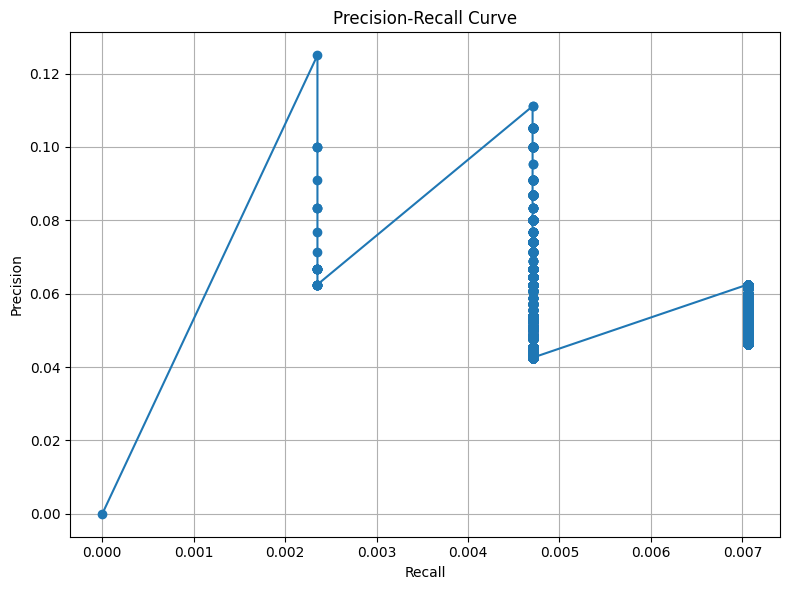

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Define the p-value thresholds
p_adj_thresholds = np.linspace(0.0000000001, 0.0001, 10000)

plt.figure(figsize=(8, 6))

precisions = []
recalls = []

for thresh in p_adj_thresholds:
    confusion = get_confusion_sets(thresh, pair_to_p_adj)
    precision = get_precision(confusion)
    recall = get_recall(confusion)
    
    if precision is not None and recall is not None:
        precisions.append(precision)
        recalls.append(recall)

plt.plot(recalls, precisions, marker='o')

# Final plot adjustments
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# Now, we want to generate a heatmap for different scoring systems and cell line numbers
def draw_precision_recall_table(p_adj_treshold, cell_line_numbers=[1, 2, 3, 4, 5], total_count=None):
    hit_rates_dict = {}
    hit_rates_dict["num_cell_lines"] = cell_line_numbers

    for scoring_system in scoring_systems_list:
        if scoring_system == "consensus" and total_count == None:
            continue
        # Create a column containing the precision for all cell line numbers
        column_name = scoring_system + "_Precision" if scoring_system != "consensus" else scoring_system + "_>=" + str(total_count) + "_Precision"
        hit_rates_dict[column_name] = []
        for num_cell_lines in cell_line_numbers:
            hit_rates_dict[column_name].append(get_precision(p_adj_treshold, scoring_system, num_cell_lines, total_count))

        # Create a column containing the recall for all cell line numbers
        column_name = scoring_system + "_Recall" if scoring_system != "consensus" else scoring_system + "_>=" + str(total_count) + "_Recall"
        hit_rates_dict[column_name] = []
        for num_cell_lines in cell_line_numbers:
            hit_rates_dict[column_name].append(get_recall(p_adj_treshold, scoring_system, num_cell_lines, total_count))

    hit_rates_df = pd.DataFrame(hit_rates_dict)
    return hit_rates_df

p_adj_treshold = 0.001
hit_rates_df = draw_precision_recall_table(p_adj_treshold, total_count=3)

hit_rates_df

,num_cell_lines,GEMINI-Score_Precision,GEMINI-Score_Recall,HORLBECK-Score_Precision,HORLBECK-Score_Recall,MAGECK-Score_Precision,MAGECK-Score_Recall,MEDIAN-B/NB Score_Precision,MEDIAN-B/NB Score_Recall,sgRNA-Derived B/NB Score_Precision,sgRNA-Derived B/NB Score_Recall,consensus_>=3_Precision,consensus_>=3_Recall
0,1,0.008696,0.016529,0.008696,0.011561,0.004348,0.008065,0.004348,0.008696,0.008696,0.01626,0.004348,0.016393
1,2,0.004348,0.052632,0.004348,0.052632,0.004348,0.111111,0.000000,0.000000,0.004348,0.06250,0.004348,0.333333
2,3,0.004348,0.200000,0.004348,0.500000,0.004348,0.500000,0.000000,0.000000,0.004348,0.50000,0.004348,1.000000
3,4,0.000000,0.000000,0.004348,1.000000,0.004348,1.000000,0.000000,NaN,0.004348,1.00000,0.000000,NaN
4,5,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN


In [ ]:
p_adj_treshold = 0.001
scoring_system = "consensus"
num_cell_lines = 3
test = get_confusion_sets(p_adj_treshold, scoring_system, num_cell_lines, total_count=3, print_tables=True)
precision = get_precision(p_adj_treshold, scoring_system, num_cell_lines, total_count=3)
recall = get_recall(p_adj_treshold, scoring_system, num_cell_lines, total_count=3)
print(f"precision: {precision}")
print(f"recall: {recall}")

True Positives (TP): 1
{('SMARCA2', 'SMARCA4')}
False Positives (FP): 229
{('PBRM1', 'UBA5'), ('EED', 'TAF1D'), ('COQ4', 'KMT2C'), ('ATP6V1G1', 'PBRM1'), ('BAP1', 'FAM50A'), ('PBRM1', 'SEC61A1'), ('ARID2', 'SDHD'), ('COX5B', 'SMARCA4'), ('ARID1A', 'MRPL36'), ('KLF5', 'PBRM1'), ('EFR3A', 'PBRM1'), ('ARID1B', 'SEPSECS'), ('MICOS10', 'SETD2'), ('ARID1B', 'TAF10'), ('ARID1A', 'ATP1B3'), ('KMT2C', 'UQCRC1'), ('ARID1A', 'MICOS10'), ('BAP1', 'CDS2'), ('COPS4', 'PBRM1'), ('PBRM1', 'VPS37A'), ('SEPHS2', 'SMARCA4'), ('ARHGEF7', 'PBRM1'), ('ARID2', 'COX5B'), ('SMARCA2', 'TRIM37'), ('CRKL', 'SMARCA2'), ('ARID1B', 'CDS2'), ('ARID2', 'RARS2'), ('LIMS1', 'PBRM1'), ('KMT2C', 'SDHD'), ('SDHD', 'SMARCA4'), ('FECH', 'SMARCA4'), ('SMARCA4', 'TTF2'), ('ARID2', 'TOMM22'), ('EED', 'WWTR1'), ('EP300', 'SETD2'), ('KMT2C', 'SUPT7L'), ('NAMPT', 'SMARCA4'), ('EP300', 'KMT2D'), ('ADSL', 'KMT2C'), ('BAP1', 'SEPHS2'), ('EP300', 'KMT2C'), ('PBRM1', 'UBA52'), ('KMT2C', 'MRPS21'), ('BAP1', 'HSPA8'), ('MARK2', 'PBRM1'),